# Cod AFSC GAP Example
Focusing on the Gulf of Alaska, this example "tutorial" notebook demonstrates a practical example of using the Python [afscgap](https://pyafscgap.org) library, both in simple usage and with [zero catch record inference](https://pyafscgap.org/docs/inference/) enabled. It uses these tools to investigate a major stock decrease for Pacific cod (Gadus macrocephalus) after a warming event called "The Blob" which took place from 2014 to 2016.

**[A Samuel Pottinger](https://gleap.org)**  
**2023-03-03** (Updated 2025-01-08)  
**[UC Berkeley](https://dse.berkeley.edu/)**  

![Picture of a large ship in the Gulf of Alaska](https://pyafscgap.org/community/kodiak.jpg)

Image: [Old Womans Bay, Kodiak - Mountainous island in the distance](https://www.flickr.com/photos/95525894@N02/8714889934) by [alexaleutians](https://www.flickr.com/photos/95525894@N02) is licensed under [CC BY 2.0](https://creativecommons.org/licenses/by/2.0/?ref=openverse).

<br>

## Summary / Abstract

To demonstrate the use of the `afscgap` Python library and provide a community tutorial, this notebook looks at a sharp decline in Pacific cod (Gadus macrocephalus) presence in the Gulf of Alaska before and after "The Blob" heating event. To facilitate this comparison, it looks at 2013 vs 2021. Using data from [NOAA AFSC GAP](https://www.fisheries.noaa.gov/foss/f?p=215:28), this notebook finds further confirmatory evidence of that [well documented species decline](https://www.npr.org/2019/12/08/785634169/alaska-cod-fishery-closes-and-industry-braces-for-ripple-effect) with geospatial visualizations showing areas of reduced catch during bottom trawl surveys. Furthermore, this work finds that reduced stock still persists despite the warming event having "ended" some years prior. Altogether, this notebook joins other anlysis in warning of ecological and economic threats in the area caused by climate change.

In [1]:
YEARS_AVAILABLE = [1993, 1996, 1999, 2001, 2003, 2005, 2007, 2009, 2011, 2013, 2015, 2017, 2019, 2021, 2023]

Users may consider, after running the notebook with these default parameters, trying different values and re-running to see how results change. These high level constants control aggregation, visualization, and query parameters:

In [2]:
MAX_POINT_AREA = 1000
GEOHASH_SIZE = 4
BEFORE_YEAR = 2013
AFTER_YEAR = 2021
SPECIES = 'Gadus macrocephalus'
P_THRESHOLD = 0.05

To ensure validity of these constants, some simple checks are made.

In [3]:
assert BEFORE_YEAR in YEARS_AVAILABLE
assert AFTER_YEAR in YEARS_AVAILABLE

Thanks to [Color Brewer 2](https://colorbrewer2.org/#type=sequential&scheme=BuGn&n=3) for help with these color-deficient-safe colors:

In [4]:
BEFORE_COLOR = '#33a02c80'
AFTER_COLOR = '#1f78b480'

<br>

## Background

[Gadus macrocephalus (pacific cod)](https://en.wikipedia.org/wiki/Pacific_cod) are a [particularly valuable species for fisheries](https://www.fisheries.noaa.gov/feature-story/tracking-cod-aleutian-islands). However, [their stock numbers saw a decline in the Gulf of Alaska](https://www.npr.org/2019/12/08/785634169/alaska-cod-fishery-closes-and-industry-braces-for-ripple-effect). In particular, the so called "Blob" heating event saw major temperature increases. This had major impact on the region and [prior work shows that this temperature increase may have had negative impact on spawning habitat](https://cdnsciencepub.com/doi/full/10.1139/cjfas-2019-0238). Regardless, this event ultimately caused the federal cod fishery to close for the 2020 season with concerns that continued climate change will further stress the species in the future. For more information, see a [related blog series from Ben Laurel at NOAA Fisheries](https://www.fisheries.noaa.gov/science-blog/young-fish-provide-clues-future-pacific-cod-stock-size-post-1).

![Picture of Pacific Cod](https://pyafscgap.org/community/cod_image_noaa_public.jpg)

Image: [Pacific Cod](https://www.fisheries.noaa.gov/species/pacific-cod) by NOAA.

The later parts of this notebook provide a more rigerous analysis but investigation can simply start by looking at the number of cod specimen found before and after the blob in the Gulf of Alaska. This also provides a simplistic example of `afscgap` before getting into more advanced use cases.

In [5]:
import afscgap

In [6]:
query = afscgap.Query()
query.filter_srvy(eq='GOA')
query.filter_scientific_name(eq=SPECIES)

This notebook uses two executions: one with `BEFORE_YEAR` and one with `AFTER_YEAR`. This next snippet filters and executes for the first year. This will query a bit of data so it might take a moment.

In [7]:
query.filter_year(eq=BEFORE_YEAR)
results_before = query.execute()

Next, an execution for the second year.

In [8]:
query.filter_year(eq=AFTER_YEAR)
results_after = query.execute()

Query's `execute` uses the latest provided values at the time it is called. In other words, calling `filter_year` a second time overwrites the year filter created by the first call to `filter_year`. This lets one use the same Query object to make multiple related searches without needing to re-specify all of the filters from scratch. Regardless, with these two result sets in place, the notebook can get the overall counts.

In [9]:
count_before = sum(map(lambda x: x.get_count(), results_before))
count_after = sum(map(lambda x: x.get_count(), results_after))

In [10]:
template_vals = (count_before, BEFORE_YEAR, count_after, AFTER_YEAR)
template = '%.0f specimen found in %d and %.0f specimen found in %d'
print(template % template_vals)

16972 specimen found in 2013 and 4013 specimen found in 2021


<br>

## Method

While the overall count provides an interesting starting point, each year's survey may not look at exactly the same areas. Therefore, this notebook demonstrates use of [afscgap](https://pyafscgap.org) by plotting [Gadus macrocephalus (pacific cod)](https://en.wikipedia.org/wiki/Pacific_cod) in the Gulf of Alaska after normalizing weight by area swept. It leverages a modern stack:

 - [geolib](https://pypi.org/project/geolib/) to aggregate by [geohash](https://en.wikipedia.org/wiki/Geohash)
 - Plots via [Cartopy](https://pypi.org/project/Cartopy/) and [Matplotlib](https://matplotlib.org/).
 - Manipulation via [Pandas](https://pandas.pydata.org/).
 - Statistical test by [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html).

It does this to show how to work with these data, both in a memory efficient way prior to aggregation by geohash where the dataset is quite large and when the data fit into a more "typical" data frame. Specifically, weight and area swept are aggregated by geohash to get a map of overall catch weight per unit effort across the Gulf of Alaska before plotting some summary statistics and executing a statistical test.

In [11]:
import copy
import math

import cartopy.crs
import geolib.geohash
import matplotlib.pyplot
import pandas
import scipy.stats

#### Query

This notebook next offers a method to execute a query for a given year. Note that this uses `set_presence_only(False)`. This enables [zero catch record inference](https://pyafscgap.org/docs/inference/) and is necessary in this case becuase the official API service will get "presence-only" data that, while much more compact, can't report on hauls when the species of interest was not found.

In [12]:
def make_query(year):
    query = afscgap.Query()
    query.filter_srvy(eq='GOA')
    query.filter_year(eq=year)
    query.filter_scientific_name(eq=SPECIES)
    query.set_presence_only(False)
    query.set_suppress_large_warning(True)
    results = query.execute()
    
    simplified_results = map(simplify_record, results)
    aggregated_results = aggregate_geohashes(simplified_results)
    return aggregated_results

To understand the need for this feature consider that this notebook aims to, per [geohash](https://www.pubnub.com/learn/glossary/what-is-geohashing/), get total weight of species of interest divided by total area swept. However, notice that it must include area swept for all hauls in an area. The official NOAA AFSC GAP API on its own [does not yield records for a species in a haul if no specimens of that species were found](https://www.fisheries.noaa.gov/foss/f?p=215:28). Therefore, it requires that the `afscgap` library infer hauls without the species of interest found. It does this by comparing results from the official API service to a metadata record of all hauls conducted.

#### Aggregation and simplification

This noteboook simplifies the [Record objects](https://pyafscgap.org/devdocs/afscgap/model.html#Record) returned by afscgap, taking a small subset of their data and putting them into dictionaries as they are returned from the library along with a [geohash](https://www.pubnub.com/learn/glossary/what-is-geohashing/).

In [13]:
def simplify_record(full_record):
    latitude = full_record.get_latitude(units='dd')
    
    longitude = full_record.get_longitude(units='dd')
    if longitude > 0:
        longitude = longitude * -1
    
    return {
        'geohash': geolib.geohash.encode(latitude, longitude, GEOHASH_SIZE),
        'area': full_record.get_area_swept(units='ha'),
        'weight': full_record.get_weight(units='kg')
    }

This notebook aggregates data, collecting into a dictionary. This reduces memory load because information is streamed in but, instead of maintaining individual records per haul, summarizes those data by geohash as they become available. This avoids loading the entire dataset in memory.

In [14]:
def aggregate_geohashes(results):
    results_agg = {}
    
    for result in results:
        geohash = result['geohash']
        
        if geohash not in results_agg:
            results_agg[geohash] = {
                'geohash': geohash,
                'area': 0,
                'weight': 0
            }
        
        results_agg[geohash]['area'] += result['area']
        results_agg[geohash]['weight'] += result['weight']
    
    return results_agg.values()

#### Calculate weight per area

Next, the notebook needs to calculate weight per area swept.

In [15]:
def summarize_data(target):
    point = geolib.geohash.decode(target['geohash'])
    
    target_copy = copy.deepcopy(target)
    target_copy['latitude'] = point[0]
    target_copy['longitude'] = point[1]
    target_copy['weightPerArea'] = target_copy['weight'] / target['area']
    
    return target_copy

#### Execute statistical test

Finally, the notebook looks for geohashes with hauls in both surveys to conduct a [Wilcoxon signed-rank test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html). Note that it does this by joining geohashes from the `BEFORE_YEAR` with the geohashes from the `AFTER_YEAR` for pairwise comparison.

In [16]:
def execute_test(before_data, after_data):
    before_data_by_geohash = dict(map(lambda x: (x['geohash'], x), before_data))
    after_data_by_geohash = dict(map(lambda x: (x['geohash'], x), after_data))
    
    before_geohashes = set(before_data_by_geohash.keys())
    after_geohashes = set(after_data_by_geohash.keys())
    overlap_geohashes = sorted(before_geohashes.intersection(after_geohashes))
    
    before_weights_by_area = [
        before_data_by_geohash[geohash]['weightPerArea'] for geohash in overlap_geohashes
    ]
    after_weights_by_area = [
        after_data_by_geohash[geohash]['weightPerArea'] for geohash in overlap_geohashes
    ]
    
    results = scipy.stats.wilcoxon(
        before_weights_by_area,
        after_weights_by_area
    )
    
    return {'p': results[1], 'statistic': results[0]}

<br>

## Results

This notebook next downloads data from the two years selected and summarizes using the utility functions.

In [17]:
raw_data_by_geohash_before = make_query(BEFORE_YEAR)
summarized_data_before = [summarize_data(record) for record in raw_data_by_geohash_before]
frame_before = pandas.DataFrame(summarized_data_before)

In [18]:
raw_data_by_geohash_after = make_query(AFTER_YEAR)
summarized_data_after = [summarize_data(record) for record in raw_data_by_geohash_after]
frame_after = pandas.DataFrame(summarized_data_after)

With these data in place, the notebook can now turn to examining these results in detail before executing a statistical test.

#### Get totals

An easy first step is simply displaying how the overall numbers from the Gulf of Alaska surveyed changed between years adjusting for area swept.

In [19]:
before_weight_per_hectare = frame_before['weight'].sum() / frame_before['area'].sum()
print('Kilograms of %s / hectare from %d: %.2f' %(SPECIES, BEFORE_YEAR, before_weight_per_hectare))

Kilograms of Gadus macrocephalus / hectare from 2013: 19.73


In [20]:
after_weight_per_hectare = frame_after['weight'].sum() / frame_after['area'].sum()
print('Kilograms of %s / hectare from %d: %.2f' %(SPECIES, AFTER_YEAR, after_weight_per_hectare))

Kilograms of Gadus macrocephalus / hectare from 2021: 5.93


Source of data: AFSC GAP


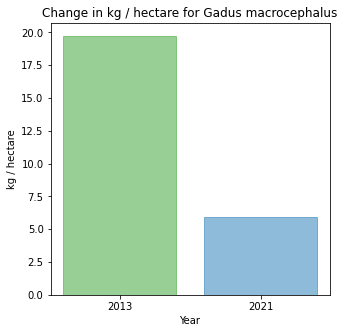

In [21]:
fig = matplotlib.pyplot.figure(figsize=(5,5))
ax = fig.add_subplot(111)
bars = ax.bar([str(BEFORE_YEAR), str(AFTER_YEAR)], [before_weight_per_hectare, after_weight_per_hectare])
bars[0].set_color(BEFORE_COLOR)
bars[1].set_color(AFTER_COLOR)
ax.set_title('Change in kg / hectare for %s' % SPECIES)
ax.set_xlabel('Year')
ax.set_ylabel('kg / hectare')

print('Source of data: AFSC GAP')

Comparing 2013 and 2021, there is a large decrease in kg / hectare.

#### Histogram of geohash weight / area swept

Next, the notebook can visualize how the distribution of weights / area in terms of geohashes examined differs per year. For convienence, this notebook filters out geohashes with zero catches.

In [22]:
max_value = max([frame_after['weightPerArea'].max(), frame_before['weightPerArea'].max()])

In [ ]:
fig = matplotlib.pyplot.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.hist(
    frame_before['weightPerArea'],
    30,
    range=[0, max_value],
    color=BEFORE_COLOR,
    density=True,
    label=BEFORE_YEAR
)
ax.hist(
    frame_after['weightPerArea'],
    30,
    range=[0, max_value],
    color=AFTER_COLOR,
    density=True,
    label=AFTER_YEAR
)
ax.set_title('Distribution of kg / hectare by geohash for %s' % SPECIES)
ax.set_xlabel('kg / hectare')
ax.set_ylabel('Density')
ax.legend()

print('Source of data: AFSC GAP')

Comparing 2013 and 2021, there is a leftward shift in distribution of kg / hectare by geohash examined.

#### Scaffolding for geographic visualizations

This notebook next turns to visualize the weights / area swept but, to facilitate, will calculate the area of dots in a bubble / scatter plot using a scale shared across both years.

In [ ]:
def scale_value(target):
    return (target / max_value) * MAX_POINT_AREA

def unscale_value(target):
    return target / MAX_POINT_AREA * max_value

In [ ]:
def render_chart(frames, colors, labels, legend_type):
    fig = matplotlib.pyplot.figure(figsize=(15,15))
    ax = fig.add_subplot(projection=cartopy.crs.PlateCarree())
    ax.coastlines(resolution='50m', color='#A0A0A0', linewidth=1)

    # Plot body
    def plot_single(frame, color, label):
        scatter = ax.scatter(
            frame['longitude'],
            frame['latitude'],
            label=str(label),
            s=frame['pointArea'],
            c=color,
            alpha=0.5
        )
        
        return scatter
    
    elements = zip(frames, colors, labels)
    scatters = [plot_single(*x) for x in elements]
    
    labels_csv = ', '.join(map(str, labels))
    ax.set_title('Distribution (kg / hectare) of %s in %s' % (SPECIES, labels_csv))
    
    if legend_type == 'area':
        scatter = scatters[0]
        legend_increment = round(max_value / 4)
        legend_indicies = [1, 2, 3, 4]
        legend_vals_raw = map(lambda x: int(x * legend_increment), legend_indicies)
        legend_vals = [round(x) for x in legend_vals_raw]
        lengend_vals_str = ['%d kg / hectare' % x for x in legend_vals]
        legend_areas = [scale_value(x) for x in legend_vals]
        legend_handles, _ = scatter.legend_elements('sizes', num=legend_areas)
        ax.legend(legend_handles, lengend_vals_str, loc='upper left')
    elif legend_type == 'color':
        ax.legend()

    print('Source of data: AFSC GAP')

In [ ]:
frame_before['pointArea'] = frame_before['weightPerArea'].apply(scale_value)
frame_after['pointArea'] = frame_after['weightPerArea'].apply(scale_value)

#### Geographic distribution in before year

Starting with the earlier "before" year, this notebook uses the calculations from before to plot them on a map.

In [ ]:
render_chart([frame_before], ['#33a02c'], [BEFORE_YEAR], 'area')

Note that, in 2013, AFSC GAP saw very large western observations especially near [Kodiak Island](https://en.wikipedia.org/wiki/Kodiak_Island).

#### Geographic distribution in before year

Next, the notebook does the same with the later "after" year.

In [ ]:
render_chart([frame_after], ['#1f78b4'], [AFTER_YEAR], 'none')

Compared to 2013, the large observations near Kodiak Island decrease in 2021 though some larger observations appear in the east. 

#### Geographic distribution in before year

Next, the notebook overlays the two years for easier comparison.

In [ ]:
render_chart([frame_before, frame_after], ['#33a02c', '#1f78b4'], [BEFORE_YEAR, AFTER_YEAR], 'color')

Overlaying the two years together may help highlight the geohashes with dramatically reduced presence in the west.

#### Statistical test

Next, this notebook evaluates if the change is statistically significant for overlapping geohashes.

In [ ]:
test_results = execute_test(summarized_data_before, summarized_data_after)

In [ ]:
template_vals = (BEFORE_YEAR, AFTER_YEAR, SPECIES, P_THRESHOLD)

if test_results['p'] < 0.05:
    template = 'Geohashes observed in %d saw significantly different kg / hectare than %d for %s (p < %.2f).'
else:
    template = 'Geohashes observed in %d not significantly different kg / hectare than %d for %s (p >= %.2f).'

message = template % template_vals
print(message)

<br>

## Discussion

This notebook observes a sizable drop in weight normalized by area swept for Pacific cod when comparing 2013 to 2021. Notably, this observes low presence some time after "The Blob" warming event, possibly suggesting that the impacts of similar phenomena may last even after the warming itself subsides. Furthermore, this example observes remarkably smaller kg / hectare observations near Kodiak Island when comparing 2013 to 2021. Unfortunately, the slightly elevated 2021 observations in the east may not offset those no longer seen in the west.

Of course, these data are not perfect. It's possible that the same species shifted geographically outside the surveyed area or some other difference between the surveys exists to cause lower reporting. Furthermore, aggregation uses a single latitude / longitude point and it remains possible that a haul may spill out of a geohash, causing some approximation in CPUE calculation. Finally, what NOAA reports as a haul is important and some surveys do not record into the hauls record those which yielded no specimens at all of any species. This potentially causes approximation in CPUE depending on the defintion of effort (should it include only hauls which "successfully" yielded specimens of any species). However, in combination with [research on mechanistic understanding of Pacific cod reductions due to warming](https://cdnsciencepub.com/doi/full/10.1139/cjfas-2019-0238), the case for warming itself explaining these findings remains strong.

Given their importance to human communities along with continued climate change, these results may suggest that a mechanism may exist for similar warming events in the region to inflict not just further ecological but also economic harm to the region.

All this in mind, this short exploration ends with a look at sample sizes.

In [ ]:
def get_frame_sizes(target):
    total = target.shape[0]
    zero_records = target[target['weightPerArea'] == 0].shape[0]
    return {'total': total, 'zeroRecords': zero_records}

sizes_before = get_frame_sizes(frame_before)
before_params = (BEFORE_YEAR, sizes_before['total'], sizes_before['zeroRecords'])
print('%d: %d geohashes of which %d had zero catch' % before_params)

sizes_after = get_frame_sizes(frame_after)
after_params = (AFTER_YEAR, sizes_after['total'], sizes_after['zeroRecords'])
print('%d: %d geohashes of which %d had zero catch' % after_params)

Note that those geohashes with zero catch would not have been included without `set_presence_only(False)` which enables zero catch inference.

<br>

## Conclusion

This notebook provides an example use of the [afscgap Python library](https://pyafscgap.org) to conduct analysis / visualization of important biological data as demonstrated by examination of Pacific cod (Gadus macrocephalus) declines in the Gulf of Alaska. This "tutorial notebook" offers examples both of simple query usage as shown in Background and advanced usage as demonstrated in the Methods section. Furthermore, this work offers a memory-efficient example of working with zero catch inference. Though some confounders may still exist, these data confirm prior work and further emphasize the ecological and economic risk posed by warming in the region. Analysis highlights that threats to the human food system continue to persist in the area with plausible links to climate change.

<br>

## Works Cited

 - "AFSC Groundfish and Crab Assessment Program Bottom Trawl Surveys." AFSC Gap Survey, NOAA Fisheries, https://www.fisheries.noaa.gov/foss/f?p=215%3A28. 
 - Brewer, Cynthia, and Mark Harrower. "Colorbrewer 2.0." ColorBrewer, The Pennsylvania State University, 3 May 2021, https://colorbrewer2.org/#type=sequential&amp;scheme=BuGn&amp;n=3. 
 - "Cartopy 0.21.1." Introduction - Cartopy 0.21.0 Documentation, British Crown / Cartopy Contributors, 12 Dec. 2022, https://scitools.org.uk/cartopy/docs/latest/. 
 - "Defined: What Is Geohashing?" Glossary, PubNub, https://www.pubnub.com/learn/glossary/what-is-geohashing/. 
 - George, Kavitha. "Alaska Cod Fishery Closes and Industry Braces for Ripple Effect." NPR, NPR, 8 Dec. 2019, https://www.npr.org/2019/12/08/785634169/alaska-cod-fishery-closes-and-industry-braces-for-ripple-effect. 
 - Joy, Anu. "Geolib 1.0.7." GitHub, GitHub, 4 May 2019, https://github.com/joyanujoy/geolib.
 - Laurel, Ben. "Young Fish Provide Clues to Future Pacific Cod Stock Size - Post 1." Science Blog, NOAA Fisheries, 3 July 2018, https://www.fisheries.noaa.gov/science-blog/young-fish-provide-clues-future-pacific-cod-stock-size-post-1. 
 - Laurel, Benjamin J., and Lauren A. Rogers. "Loss of Spawning Habitat and Prerecruits of Pacific Cod during a Gulf of Alaska Heatwave." Canadian Journal of Fisheries and Aquatic Sciences, vol. 77, no. 4, 23 Jan. 2020, pp. 644–650., https://doi.org/10.1139/cjfas-2019-0238. 
 - Lindeman, Alex. "Old Womans Bay, Kodiak - Mountainous Island in the Distance." Flickr, Yahoo!, 6 May 2013, https://www.flickr.com/photos/95525894@N02/8714889934. 
 - "Pacific Cod." Species Directory, NOAA Fisheries, 23 Nov. 2022, https://www.fisheries.noaa.gov/species/pacific-cod. 
 - "Pacific Cod." Wikipedia, Wikimedia Foundation, 26 Feb. 2023, https://en.wikipedia.org/wiki/Pacific_cod. 
 - "Pandas 1.5.3." Pandas, NumFOCUS, 19 Jan. 2023, https://pandas.pydata.org/.
 - "Tracking Cod in the Aleutian Islands." News, NOAA Fisheries, https://www.fisheries.noaa.gov/feature-story/tracking-cod-aleutian-islands.
 - Virtanen, Pauli, et al. "SciPy 1.0: Fundamental Algorithms for Scientific Computing in Python." Nature Methods, vol. 17, no. 3, 2020, pp. 261–272., https://doi.org/10.1038/s41592-019-0686-2. 